## Обзор и предобработка данных

# Исследование поведения пользователей мобильного приложения 

Цель проекта проанализировать поведение пользователей мобильного приложения:
* изучить воронку продаж
* исследовать результаты А/А/В-эксперимента.

Описание данных `/datasets/logs_exp.csv`

Каждая запись в логе — это действие пользователя, или событие:
* `EventName` — название события;
* `DeviceIDHash` — уникальный идентификатор пользователя;
* `EventTimestamp` — время события;
* `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

План действий: 
1. Обзор и предобработка данных 
2. Изучение и проверка данных
3. Изучение воронки событый 
4. Изучение результатов эксперимента

In [1]:
# импорт библиотек 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
import plotly.graph_objects as go
from scipy import stats as st

In [2]:
log = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
display(log.head())
display(log.info())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

In [3]:
# проверим наличие будликатов
log.duplicated().sum()

413

In [4]:
# проверим номера экспериментов 
display(log['ExpId'].unique())

array([246, 248, 247])

Номера экспериментов совпадают с ТЗ. Пропусков нет, есть 413 дубликатов.

Столбец со временем событий нужно привести в нужный формат (кажется, они указаны в секундах), названия столбцов перезапишем в удобном нам стиле, избавимся от дубликатов и добавим столбцы с датой и временем.

In [5]:
# поменяем названия столбцов
log = log.rename(columns = {'EventName':'event', 'DeviceIDHash':'user_id', 
                            'EventTimestamp':'timestamp', 'ExpId':'group_id'})

In [6]:
# стобец с датами приведем в нужный формат с точностью до секунды
log['timestamp'] = log['timestamp'].astype('datetime64[s]')

In [7]:
# добавим столбец даты и времени, а также отдельный столбец дат
log['date_time'] = pd.to_datetime(log['timestamp'], unit='s') 
log['date'] = log['date_time'].astype('datetime64[D]')

In [8]:
# удалим дубликаты
log = log.drop_duplicates()

**Вывод**

Провели предобработку и привели данные в порядок. Исправили формат колонки с датой, добавили столбцы с датой и временем, а также отдельный столбец с датой. Также переписали названия в едином стиле для удобной работы.

In [9]:
log.sample(5)

,event,user_id,timestamp,group_id,date_time,date
151951,CartScreenAppear,1100007125648169445,2019-08-05 10:12:17,248,2019-08-05 10:12:17,2019-08-05
159167,MainScreenAppear,422635451750847294,2019-08-05 13:24:38,247,2019-08-05 13:24:38,2019-08-05
230910,CartScreenAppear,8685495455749621832,2019-08-07 14:15:10,247,2019-08-07 14:15:10,2019-08-07
89267,MainScreenAppear,3808350110501887887,2019-08-03 11:45:46,248,2019-08-03 11:45:46,2019-08-03
29779,MainScreenAppear,1866081895270239546,2019-08-01 16:42:29,247,2019-08-01 16:42:29,2019-08-01


## Изучение и проверка данных

* Сколько всего событий в логе?
* Сколько всего пользователей в логе?
* Сколько в среднем событий приходится на пользователя?
* Данными за какой период мы располагаем? Найдем максимальную и минимальную дату. Изучим, как меняется количество данных: построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можно ли быть уверенным, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определить, с какого момента данные полные и отбросить более старые. Данными за какой период времени мы располагаем на самом деле?
* Много ли событий и пользователей вы потеряли, отбросив старые данные?
* Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

### Сколько всего событий в логе?

In [9]:
display(log['event'].unique())
print('Всего уникальных событий в логе:', len(log['event'].unique()))

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Всего уникальных событий в логе: 5


In [10]:
print('Всего событий в логе:', log['event'].count())

Всего событий в логе: 243713


### Сколько всего пользователей в логе?

In [11]:
print('Число пользователей в логе:', len(log['user_id'].unique()))

Число пользователей в логе: 7551


### Сколько в среднем событий приходится на пользователя?

In [12]:
print('В среднем на одного пользователя приходится событий:', log.groupby('user_id')['event'].count().mean().round(1))

В среднем на одного пользователя приходится событий: 32.3


### Данными за какой период мы располагаем? 
Найдем максимальную и минимальную дату. Изучим, как меняется количество данных:
построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можно ли быть уверенным, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определить, с какого момента данные полные и отбросить более старые. Данными за какой период времени мы располагаем на самом деле?

In [13]:
# найдем первую и последнюю даты
first_date = log['date'].min()
last_date = log['date'].max()
print('Первый день:', first_date)
print('Последний день:', last_date)

Первый день: 2019-07-25 00:00:00
Последний день: 2019-08-07 00:00:00


In [14]:
# определим данными за какой период мы располагаем
diff = last_date - first_date
print('Период:', diff)

Период: 13 days 00:00:00


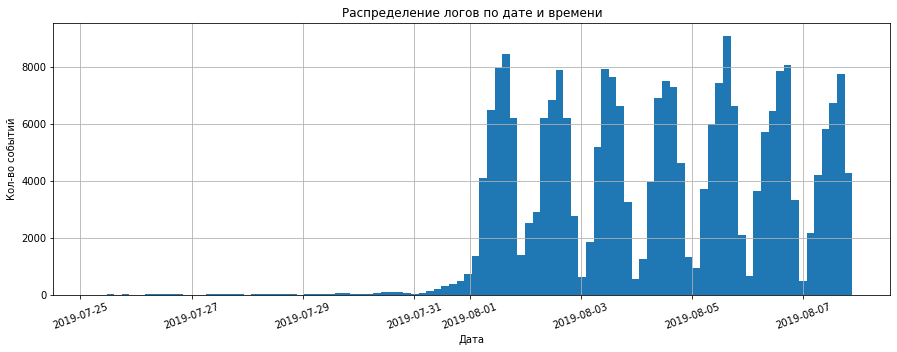

In [15]:
# посмотрим на графике кол-во событий в зависимости от времени 
log['date_time'].hist(bins=100, figsize=(15, 5))

plt.title('Распределение логов по дате и времени')
plt.xlabel('Дата')
plt.ylabel('Кол-во событий')
plt.xticks(rotation=20)

plt.show()

Мы видим, что данные не пошли с самого начала. Иногда так бывает, что, например, у пользователя нет интернета, он пользовался приложением, данные сохранились в логе, а потом, когда появился интернет, они отправились.

Поэтому, чтобы избежать данной проблемы, мы берем данные с 01-08-2019 по 07-08-2019.

In [16]:
log_upd = log[log['date_time'] >= '2019-08-01']

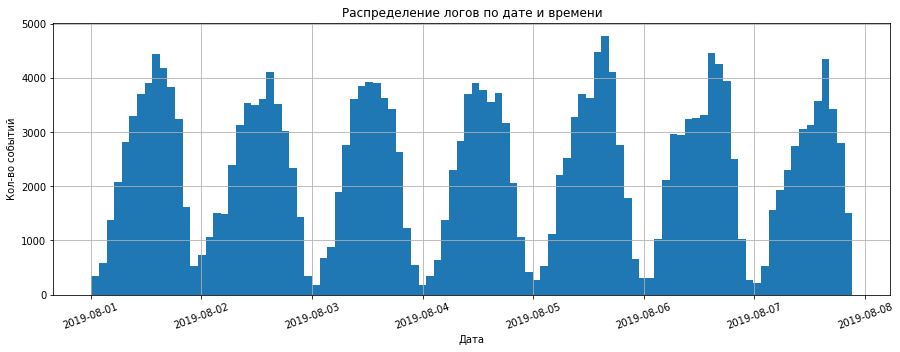

In [17]:
# посмотрим на графике кол-во событий в зависимости от времени (по очищенным данным)
log_upd['date_time'].hist(bins=100, figsize=(15, 5))

plt.title('Распределение логов по дате и времени')
plt.xlabel('Дата')
plt.ylabel('Кол-во событий')
plt.xticks(rotation=20)

plt.show()

Изначально в нашем распоряжении были данные за 2 недели, но после фильтрации осталась только одна.

Длительность проведения теста зависит от нескольких факторов, включая размер эффекта, который мы хотим обнаружить, уровень статистической значимости, количество участников в тесте и уровень изменчивости данных.

В идеале, тест должен продолжаться достаточно долго, чтобы получить статистически значимые результаты и убедиться, что различия между группами не случайны. Во многих случаях рекомендуется проводить тест не менее одной недели, чтобы учесть возможные изменения в поведении пользователей в разные дни недели.

### Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [18]:
# посчитаем сколько событий потеряли
print('Всего событий до очистки:', len(log['event']))
print('Всего событий после отчистки:', len(log_upd['event']))

loss_percentage = (len(log['event']) - len(log_upd['event'])) / len(log['event']) * 100
print('Потеряли:', round(loss_percentage, 2), '%')

Всего событий до очистки: 243713
Всего событий после отчистки: 240887
Потеряли: 1.16 %


In [19]:
# посчитаем сколько пользователей потеряли
print('Всего пользователей до очистки:', len(log['user_id'].unique()))
print('Всего пользователей после отчистки:', len(log_upd['user_id'].unique()))

loss_percentage = (len(log['user_id'].unique()) - len(log_upd['user_id'].unique())) / len(log['user_id'].unique()) * 100
print('Потеряли:', round(loss_percentage, 2), '%')

Всего пользователей до очистки: 7551
Всего пользователей после отчистки: 7534
Потеряли: 0.23 %


После очистки мы потеряли чуть больше 1% событий и 0,23% пользователей. 

### Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [20]:
# проверим наличие пользователей их всех 3х групп
display(log.groupby('group_id').agg({'user_id': 'nunique'})) # до отчистки
display(log_upd.groupby('group_id').agg({'user_id': 'nunique'})) # очищенные данные

,user_id
group_id,
246,2489
247,2520
248,2542


,user_id
group_id,
246,2484
247,2513
248,2537


Да, пользователи из всех 3 групп имеются и потери не такие уж и велики после очистки данных.

**Вывод**

Выяснили, что уникальных событий в логе 5, а всего 243713. Пользователей всего 7551 и в среднем на одного пользователя приходится 32 события. Имеем данные с 25 июля по 7 августа 2019 года. После того, как отбросили старые данные, теперь имеем данные с 1 по 7 августа. После очистки потеряли всего лишь чуть больше 1% событий и 0,2% пользователей, что не скажется на нашем исследовании.

## Изучение воронки событий 

* Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.
* Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.
* Посмотрим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
* По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
* На каком шаге теряем больше всего пользователей?
* Какая доля пользователей доходит от первого события до оплаты?

### Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [21]:
event_funnel = log_upd['event'].value_counts().reset_index()
event_funnel

,index,event
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


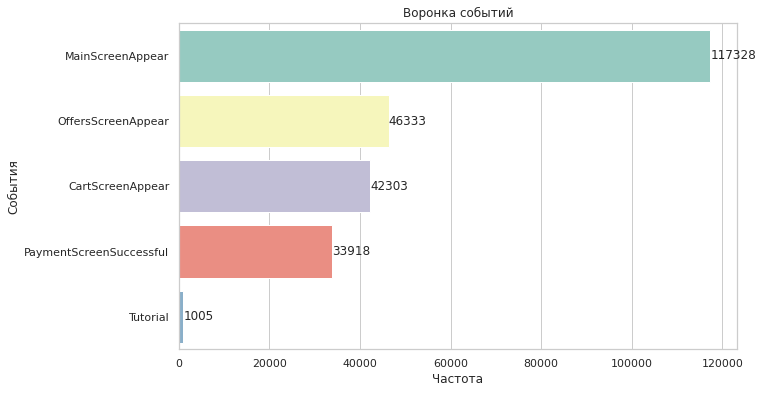

In [54]:
# создаем график воронки с помощью Seaborn и Matplotlib
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(x=event_funnel['event'], y=event_funnel['index'], palette="Set3")

for i, count in enumerate(event_funnel['event']):
    plt.annotate(count, (count, i), va='center', fontsize=12)
    
plt.xlabel('Частота')
plt.ylabel('События')
plt.title('Воронка событий')
plt.show()

In [44]:
# График воронки с помощью Plotly

#fig = go.Figure(go.Funnel(y = event_funnel['index'],
#                          x = event_funnel['event'],
#                          textposition = 'inside',
#                          textinfo = 'value+percent initial'))
#fig.update_layout(title='Частота событий')
#fig.update_layout(yaxis_title='События')
#fig.show()

Больше всего пользователей посмотрели главную страницу, что является логичным. Далее следуют страница с предложениями и корзина. Страницу с успешной оплатой посетили 33 тысячи раз. Однако страница "Tutorial" остается загадкой. По идее, она должна быть одной из первых или вторых в последовательности. Вероятно, пользователи просто пропускают этот этап.

### Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [23]:
user_funnel = log_upd.groupby('event')['user_id'].nunique()\
.sort_values(ascending=False).reset_index().rename(columns={'user_id': 'total_users'}) 
user_funnel['percent'] = round(user_funnel['total_users'] / log_upd['user_id'].nunique() * 100, 1)
user_funnel

,event,total_users,percent
0,MainScreenAppear,7419,98.5
1,OffersScreenAppear,4593,61.0
2,CartScreenAppear,3734,49.6
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,11.1


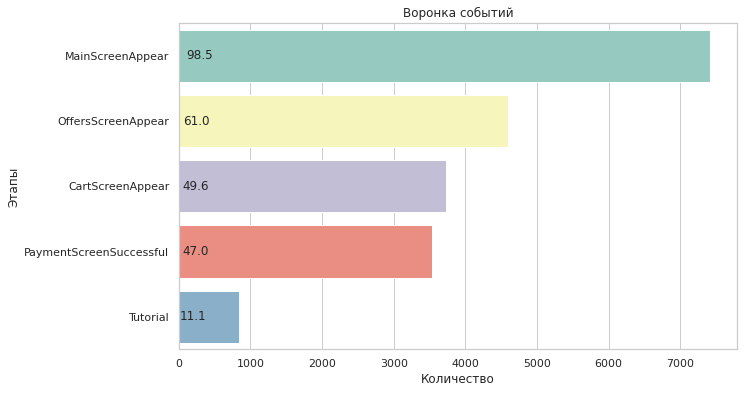

In [49]:
# создаем график воронки с помощью Seaborn и Matplotlib
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(x=user_funnel['total_users'], y=user_funnel['event'], palette="Set3")

for i, count in enumerate(user_funnel['percent']):
    plt.annotate(count, (count, i), va='center', fontsize=12)
    
plt.xlabel('Количество')
plt.ylabel('Этапы')
plt.title('Воронка событий')
plt.show()

In [51]:
# График воронки с помощью Plotly

#fig = go.Figure(go.Funnel(y = user_funnel['event'],
#                          x = user_funnel['total_users'],
#                          textposition = 'inside',
#                          textinfo = 'value+percent initial'))
#fig.update_layout(title='Воронка событий')
#fig.update_layout(yaxis_title='События')
#fig.show()

Последовательность событий не поменялось. Tutorial снова на последнем месте.

### Посмотрим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

События происходят в следующем порядке:
1. Главная страница
2. Страница с предложениями (каталог)
3. Корзина
4. Успешная оплата 
5. Инструкция.

Как уже отмечалось, Tutorial не на своем месте. Из общего числа всех событий, Tutorial занимает всего 1% событий. Если смотреть по соотношению пользователей, которые хоть раз совершили это событие, то это составляет 11%. Однако, если сравнивать с пользователями, которые видели страницу "Успешной оплаты", это соотношение очень низкое. Большинство пользователей пропускают Tutorial в приложениях, играх и т.д., полагаясь на то, что продукт не так уж и сложен в использовании. Однако, мы не можем утверждать это наверняка, так как у нас нет информации о том, как устроено приложение. Если рассматривать события без Tutorial, то все остальные шаги логичны.

### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.


In [25]:
funnel = log_upd.groupby('event')['user_id'].nunique()\
.sort_values(ascending=False).reset_index().rename(columns={'user_id': 'total_users'}) 
funnel['percent'] = round(funnel['total_users'] / log_upd['user_id'].nunique() * 100, 1)

# добавляем столбец с долями пользователей, проходящих на следующий шаг
funnel['conversion'] = round(funnel['total_users'] / funnel['total_users'].shift(1) * 100, 1)

# уберем Tutorial из таблицы (можем не учитывать)
funnel = funnel[funnel['event'] != 'Tutorial']
funnel

,event,total_users,percent,conversion
0,MainScreenAppear,7419,98.5,NaN
1,OffersScreenAppear,4593,61.0,61.9
2,CartScreenAppear,3734,49.6,81.3
3,PaymentScreenSuccessful,3539,47.0,94.8


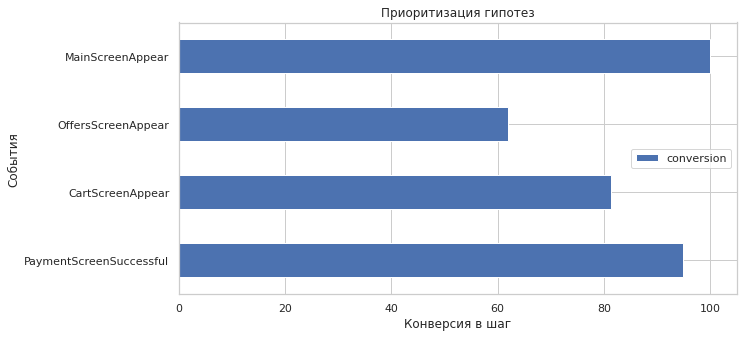

In [52]:
# заполним пропуск, чтобы график был информативнее
funnel.fillna(100, inplace=True)

# создание графика
funnel.plot(
    x='event', y='conversion', kind='barh', grid=True, figsize=(10, 5)
)
plt.xlabel('Конверсия в шаг')
plt.ylabel('События')
plt.title('Приоритизация гипотез')
plt.gca().invert_yaxis()
plt.show()

Видим, что примерно 40% пользователей не проходят дальше главной страницы. Затем, примерно 80% пользователей, которые просмотрели товары, открывают корзину. После этого, 95% пользователей, которые добавили товары в корзину, совершают покупку.

Таким образом, примерно 47% пользователей от общего числа совершают покупки.

### На каком шаге теряем больше всего пользователей?

На втором шаге теряем больше всего пользователей, около 40%. Это значительная потеря. Может быть стоит проанализировать главный экран приложения. Возможно, есть недочеты или интерфейс неудобен для использования, что сбивает пользователей с толку. Необходимо оптимизировать этот этап для улучшения пользовательского опыта. 

### Какая доля пользователей доходит от первого события до оплаты?

От первого шага - Главный экран, до последнего - Успешная оплата, доходят 47% пользователей. 47% конверсия в покупку может считаться хорошей, но оценка "хорошей" или "плохой" конверсии зависит от контекста и отрасли.

## Изучение результатов эксперимента

* Сколько пользователей в каждой экспериментальной группе?
* Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверить, находят ли статистические критерии разницу между выборками 246 и 247.
* Выбрать самое популярное событие. Посчитать число пользователей, совершивших это событие в каждой из контрольных групп. 
* Аналогично с группой с изменённым шрифтом. Сравнить результаты с каждой из контрольных групп в отдельности по каждому событию. Сравнить результаты с объединённой контрольной группой. 
* Посчитать, сколько проверок статистических гипотез мы сделали. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить? 

### Сколько пользователей в каждой экспериментальной группе?

In [27]:
users = log_upd.groupby('group_id').agg({'user_id': 'nunique'}).reset_index()
users

,group_id,user_id
0,246,2484
1,247,2513
2,248,2537


Во всех группах примерно одинаковое число пользователей. 

Стоит проверить, чтобы каждый пользователь принадлежал только одной группе. 

In [28]:
# группируем по user_id и подсчет уникальных group_id
unique_user = log_upd.groupby('user_id')['group_id'].nunique()

# проверим, принадлежит ли какой-либо пользователь более чем одной группе
if unique_user.max() > 1:
    print('Некоторые пользователи принадлежат более чем одной группе.')
else:
    print('Каждый пользователь принадлежит только одной группе.')

Каждый пользователь принадлежит только одной группе.


### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

In [29]:
log_upd = log_upd[log_upd['event'] != 'Tutorial']

aa = (log_upd.groupby(['event', 'group_id'])
                .agg({'user_id': 'nunique'})
                .reset_index()
                .pivot(index='event', columns='group_id', values='user_id').reset_index()
                .sort_values(by=[246, 247, 248], ascending=False))
aa

group_id,event,246,247,248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


Для теста определим гипотезу: 
* Нулевая гипотеза (H0): Нет статистически значимых различий между средними значениями выборок.
* Альтернативная гипотеза (H1): Существуют статистически значимые различия между средними значениями выборок.

In [30]:
# напишем функию z-тест о равенстве долей 
def z_test(df1, df2, event, alpha, n):

    # критический уровень статистической значимости c поправкой Бонферрони
    bonferroni_alpha = alpha / n
 
    # число пользователей в группе 1 и группе 2:
    n_users = np.array([df1['user_id'].nunique(), 
                        df2['user_id'].nunique()])

    # число пользователей, совершивших событие в группе 1 и группе 2
    success = np.array([df1[df1['event'] == event]['user_id'].nunique(), 
                        df2[df2['event'] == event]['user_id'].nunique()])

    # пропорции успехов в группах:
    p1 = success[0]/n_users[0]
    p2 = success[1]/n_users[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2   
    
    print('Событие:', event)
    print('p-значение: ', p_value)

    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

Когда мы проводим несколько статистических тестов одновременно, есть вероятность получить ложно положительные результаты (ошибки первого рода). Чтобы уменьшить эту вероятность, мы можем применить поправку Бонферрони. 

Поправка Бонферрони заключается в том, что мы делим уровень значимости (alpha) на количество статистических тестов, которые мы выполняем. В данном случае у нас 4 типа событий (Tutorial исключили) и 16 A/A/B тестов. 

Таким образом, для каждого теста мы используем bonferroni_alpha = alpha / 4 (для A/A тестов) или bonferroni_alpha = alpha / 12 (для A/B тестов). Это позволяет нам установить более строгий критерий для отвержения нулевой гипотезы и уменьшить вероятность получения ложно положительных результатов.

In [31]:
# проверим, есть ли статистически значимая разница между контрольными группами 246 и 247:
for event in aa['event'].unique():
    z_test(log_upd[log_upd['group_id'] == 246], log_upd[log_upd['group_id'] == 247], event, .05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Разницы между двумя контрольными группами не наблюдается. Стоит отметить, что в первом случае (Главный экран) р-значение чуть выше 7%.

Когда мы проводим z-тест, мы сравниваем две выборки или группы, чтобы определить, есть ли статистически значимая разница между ними. Нулевая гипотеза в z-тесте гласит, что нет разницы между группами.

Если мы не отвергаем нулевую гипотезу при значимости 0,05, это означает, что мы не имеем достаточных доказательств для того, чтобы утверждать, что существует статистически значимая разница между группами. Вероятность получить такие или большие различия между группами случайно составляет 7.3%, что выше уровня значимости 5%. 

Таким образом, оснований считать доли разными недостаточно, и мы не можем сделать вывод о статистически значимой разнице между группами.

### Выбрать самое популярное событие. Посчитать число пользователей, совершивших это событие в каждой из контрольных групп. 
Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

In [55]:
user_funnel

,event,total_users,percent
0,MainScreenAppear,7419,98.5
1,OffersScreenAppear,4593,61.0
2,CartScreenAppear,3734,49.6
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,11.1


### Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

Самое популярное событие это MainScreenAppear. Практически все пользователи (98%) из всех групп выполняли это действие.  

Напомним гипотезу: 
* Нулевая гипотеза (H0): Нет статистически значимых различий между средними значениями выборок.
* Альтернативная гипотеза (H1): Существуют статистически значимые различия между средними значениями выборок.

In [33]:
# проверим, есть ли статистически значимая разница между контрольной группой 246 и экпериментально 248:
for event in aa['event'].unique():
    z_test(log_upd[log_upd['group_id'] == 246], log_upd[log_upd['group_id'] == 248], event, .05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



На основе проведенного анализа, мы выяснили, что нет статистически значимых различий в долях пользователей, совершивших различные события в каждой из контрольных групп. Это означает, что все события имеют примерно одинаковую популярность среди пользователей.

In [34]:
# проверим, есть ли статистически значимая разница между контрольной группой 247 и экспериментально 248:
for event in aa['event'].unique():
    z_test(log_upd[log_upd['group_id'] == 247], log_upd[log_upd['group_id'] == 248], event, .05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Во всех событиях - MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful - не получилось отвергнуть нулевую гипотезу при уровне значимости 0.05. Это означает, что нет достаточных оснований считать доли пользователей, совершивших эти события, разными в контрольных группах.

In [35]:
# проверим, есть ли статистически значимая разница между объединенными контрольными группами 246+247 и 248:
for event in aa['event'].unique():
    z_test(log_upd[log_upd['group_id'] != 248], log_upd[log_upd['group_id'] == 248], event, .05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



При уровне значимости 0.05 не удалось отвергнуть нулевую гипотезу для всех событий: MainScreenAppear, OffersScreenAppear, CartScreenAppear и PaymentScreenSuccessful. Это означает, что нет статистически значимых различий в долях пользователей, выполнивших эти события.

### Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить? 

Мы выбрали уровень значимости 0.05.Однако следует отметить, что выбор уровня значимости 0.1 должен быть обоснован и основан на конкретных целях исследования. В некоторых случаях, особенно если исследование имеет важные последствия или требует высокой степени достоверности, более строгий уровень значимости, такой как 0.05 или 0.01, может быть предпочтительным.

Уровень значимости 0.1 может быть выбран в случаях, когда исследователи хотят быть менее строгими в отношении отклонения нулевой гипотезы. В контексте исследования мобильного приложения, это может означать, что мы можем считать результаты статистически значимыми, даже если есть некоторая вероятность ошибки первого рода (отклонения нулевой гипотезы, когда она верна).

Например, если исследователи хотят проверить, есть ли статистически значимая разница в конверсии пользователей на разных этапах взаимодействия с приложением (например, открытие главного экрана, появление предложений, добавление в корзину, успешная оплата), они могут выбрать уровень значимости 0.1, чтобы быть более гибкими в определении статистической значимости различий.


# Вывод

Мы провели исследование поведения пользователей мобильного в течении одной недели. Выполнили следующие действия:
* загрузили данные
* привели названия столбцов к единому стилю, для удобного анализа
* стоблцы с датами привели к формату datetimе
* избавились от дубликатов

Изучили воронку событий:
1. Главная страница
2. Страница с предложениями (каталог)
3. Корзина
4. Успешная оплата

Именно в такой последовательности выполнялись все действия пользвоателей. Выяснили, что на 2 шаге теряем больше всего пользователей ~ 40%. А от первого шага - Главный экран, до последнего - Умпешная оплата, доходят 47% пользователей. 

Провели А1/А2 ,  А1/В, А2/В и А1А2/В тесты. По итогам всех тестов, и ни один тест не смог отвергнуть нулевую гипотезу (Нулевая гипотеза (H0): Нет статистически значимых различий между средними значениями выборок). 
Из этого можно сделать следующие выводы:
* Наши изменения в мобильном приложении, проведенные в рамках тестов, не оказывают статистически значимого влияния на поведение пользователей.
* Возможно, нужно провести более глубокий анализ и исследование, чтобы выяснить, почему проведенные изменения не привели к статистически значимым различиям в поведении пользователей.